## Import Modules and Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.grid_search import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
np.random.seed(42)

In [3]:
train_df = pd.read_csv('./data/train_modeling.csv', index_col='Id')
test_df = pd.read_csv('./data/test_modeling.csv', index_col='Id')

## Pre-scaling

In [4]:
lr = LinearRegression()

In [5]:
y = train_df['saleprice']
X = train_df[[col for col in train_df.columns if col != 'saleprice']]

lr.fit(X,y)

lr.predict(X)
lr.score(X,y)

0.94747744064565687

## Create Train/Test Split and Scale Data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## Set Up the Pipeline

In [8]:
pipe_lasso = Pipeline([
    ('ss', StandardScaler()),
    ('var_thresh', VarianceThreshold()),
    ('kbest', SelectKBest(f_regression)),
    ('lasso', Lasso())])

pipe_ridge = Pipeline([
    ('ss', StandardScaler()),
    ('var_thresh', VarianceThreshold()),
    ('kbest', SelectKBest(f_regression)),
    ('ridge', Ridge())])

pipe_el = Pipeline([
    ('ss', StandardScaler()), 
    ('var_thresh', VarianceThreshold()),
    ('kbest', SelectKBest(f_regression)),
    ('elastic', ElasticNet())])

pipe_linear = Pipeline([
    ('ss', StandardScaler()), 
    ('var_thresh', VarianceThreshold()),
    ('kbest', SelectKBest(f_regression)),
    ('linreg', LinearRegression())])

In [9]:
params = {
    'var_thresh__threshold': [0, .05, .1],
    'kbest__k': [10, 15, 20],
    'lasso__alpha': np.logspace(-3,3,7)}

**Drop saleprice from train dataset before GridSearch**

In [10]:
train_df.drop('saleprice', axis=1, inplace=True)

## Linear Model

In [11]:
y_train.mean()

12.021720682743458

In [12]:
linear_params = {}
gs_linear = GridSearchCV(pipe_linear, linear_params)
gs_linear.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('var_thresh', VarianceThreshold(threshold=0.0)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x1a0ee07378>)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [13]:
gs_linear.score(X_train, y_train)

0.86312648607711795

In [14]:
gs_linear.score(X_test, y_test)

0.88070963001058655

In [15]:
np.sqrt(mean_squared_error(y_test, gs_linear.predict(X_test)))

0.14231203843096904

In [16]:
gs_linear.best_score_

0.859085699925934

## Lasso

In [17]:
params = {
    'var_thresh__threshold': [0, .05, .1],
    'kbest__k': [10, 15, 20],
    'lasso__alpha': np.logspace(-3,3,7)}

In [18]:
gs_lasso = GridSearchCV(pipe_lasso, params)

In [19]:
gs_lasso.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('var_thresh', VarianceThreshold(threshold=0.0)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x1a0ee07378>)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'var_thresh__threshold': [0, 0.05, 0.1], 'kbest__k': [10, 15, 20], 'lasso__alpha': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [20]:
gs_lasso.score(X_train, y_train), gs_lasso.score(X_test, y_test)

(0.87379683018167997, 0.89322814105938575)

In [21]:
gs_lasso.best_score_

0.8703667201739048

In [22]:
gs_lasso.best_params_

{'kbest__k': 20, 'lasso__alpha': 0.001, 'var_thresh__threshold': 0}

In [23]:
gs_lasso_best_var_thresh = gs_lasso.best_estimator_.named_steps['var_thresh'].get_support()

In [24]:
gs_lasso_best_kbest = gs_lasso.best_estimator_.named_steps['kbest'].get_support()

In [25]:
gs_lasso_best_estimator = gs_lasso.best_estimator_.named_steps['lasso'].coef_

In [26]:
np.sqrt(mean_squared_error(y_test, gs_lasso.best_estimator_.predict(X_test)))

0.1346379060297265

In [27]:
gs_lasso_prediction_test = gs_lasso.predict(X_test)

Text(0,0.5,'Actual Values')

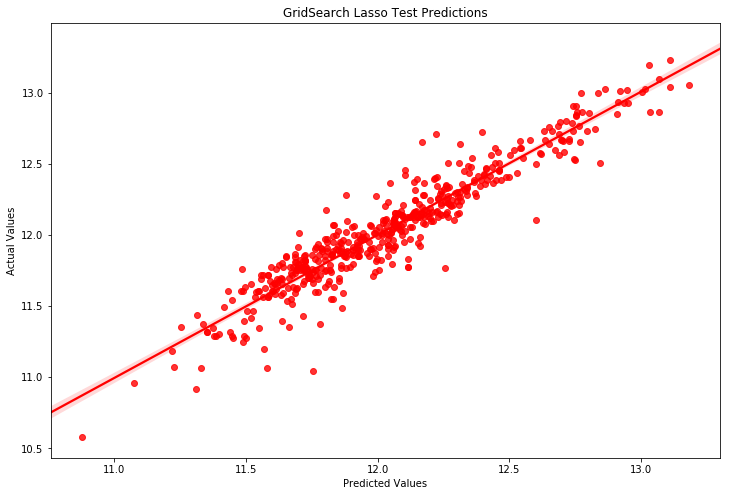

In [67]:
plt.figure(figsize=(12,8))
sns.regplot(gs_lasso_prediction_test, y_test, color='red')
plt.title("GridSearch Lasso Test Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

In [64]:
columns = train_df.columns
columns = columns[gs_lasso.best_estimator_.named_steps['var_thresh'].get_support()]
columns = columns[gs_lasso.best_estimator_.named_steps['kbest'].get_support()]

lasso_df = pd.DataFrame(gs_lasso.best_estimator_.named_steps['lasso'].coef_, 
             index = columns, 
             columns=['Coef Weights'])

lasso_df

,Coef Weights
overall_qual,0.106883
year_built,0.043262
year_remod/add,0.038354
gr_liv_area,0.034467
totrms_abvgrd,-0.004270
fireplaces,0.033896
garage_yr_blt,0.000000
garage_area,0.048451
total_area,0.128785
total_bath,0.024216


In [74]:
beta_0 = gs_lasso.best_estimator_.named_steps['lasso'].intercept_

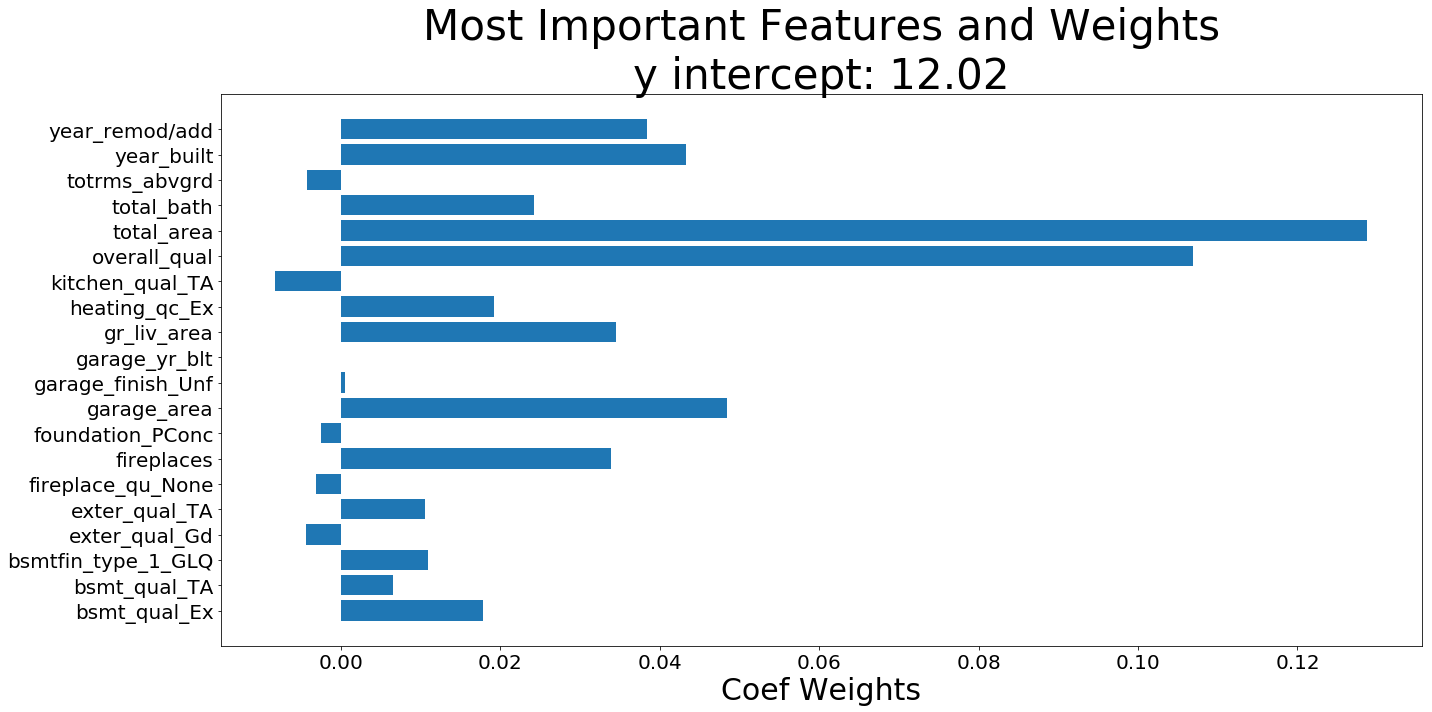

In [76]:
plt.figure(figsize=(20,10))
plt.barh(lasso_df.index, lasso_df['Coef Weights'])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Coef Weights', fontsize=30)
plt.title('Most Important Features and Weights\ny intercept: {:0.02f}'.format(beta_0), fontsize=42)
plt.tight_layout()

## Ridge

In [30]:
params = {
    'var_thresh__threshold': [0, .05, .1],
    'kbest__k': [10, 15, 20],
    'ridge__alpha': np.logspace(-3,3,7)}

In [31]:
gs_ridge = GridSearchCV(pipe_ridge, params)

In [32]:
gs_ridge.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('var_thresh', VarianceThreshold(threshold=0.0)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x1a0ee07378>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'var_thresh__threshold': [0, 0.05, 0.1], 'kbest__k': [10, 15, 20], 'ridge__alpha': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [33]:
gs_ridge.score(X_train, y_train), gs_ridge.score(X_test, y_test)

(0.87400210075513018, 0.89331647247334356)

In [34]:
gs_ridge_best_var_thresh = gs_ridge.best_estimator_.named_steps['var_thresh'].get_support()

In [35]:
gs_ridge_best_kbest = gs_ridge.best_estimator_.named_steps['kbest'].get_support()

In [36]:
gs_ridge_best_estimator = gs_ridge.best_estimator_.named_steps['ridge'].coef_

In [37]:
np.sqrt(mean_squared_error(y_test, gs_ridge.best_estimator_.predict(X_test)))

0.134582202132459

In [38]:
columns = train_df.columns
columns = columns[gs_ridge.best_estimator_.named_steps['var_thresh'].get_support()]
columns = columns[gs_ridge.best_estimator_.named_steps['kbest'].get_support()]

pd.DataFrame(gs_ridge.best_estimator_.named_steps['ridge'].coef_, 
             index = columns, 
             columns=['Coef Weights'])

,Coef Weights
overall_qual,0.106007
year_built,0.046854
year_remod/add,0.039536
gr_liv_area,0.043097
totrms_abvgrd,-0.009373
fireplaces,0.018848
garage_yr_blt,0.000137
garage_area,0.048603
total_area,0.124558
total_bath,0.024319


## Make Predictions

**Lasso Prediction**

In [39]:
pred_lasso_gs = gs_lasso.predict(test_df)

In [40]:
pred_lasso_gs_exp = np.expm1(pred_lasso_gs)

In [41]:
final_lasso_gs_df = pd.DataFrame(pred_lasso_gs_exp, index=test_df.index)

In [42]:
final_lasso_gs_df.columns = ['SalePrice']

In [43]:
final_lasso_gs_df.sort_index(inplace=True)

In [44]:
final_lasso_gs_df.to_csv('./data/final_gs_lasso.csv')

In [45]:
!head ./data/final_gs_lasso.csv

Id,SalePrice
2,124848.08265574471
4,260242.46079753377
6,201347.09086642737
7,204455.25832344173
17,191490.9454326224
18,310670.4434551764
22,168082.87473191222
27,119019.3618952791
31,115085.33364739016


**Linear Prediction**

In [46]:
pred_linear_gs = gs_linear.predict(test_df)

In [47]:
pred_linear_gs_exp = np.expm1(pred_linear_gs)

In [48]:
final_linear_gs_df = pd.DataFrame(pred_linear_gs_exp, index=test_df.index)

In [49]:
final_linear_gs_df.columns = ['saleprice']

In [50]:
final_linear_gs_df.sort_index(inplace=True)

In [51]:
final_linear_gs_df.to_csv('./data/final_gs_linear.csv')

In [52]:
!head ./data/final_gs_linear.csv

Id,saleprice
2,121282.8899043063
4,248398.74531216867
6,185189.80973429038
7,221083.20082301617
17,211346.3071769139
18,328649.7530384864
22,170083.76262561165
27,113963.05534800231
31,110446.13512996219


**Ridge Prediction**

In [53]:
pred_ridge_gs = gs_ridge.predict(test_df)

In [54]:
pred_ridge_gs_exp = np.expm1(pred_ridge_gs)

In [55]:
final_ridge_gs_df = pd.DataFrame(pred_ridge_gs_exp, index=test_df.index)

In [56]:
final_ridge_gs_df.columns = ['saleprice']

In [57]:
final_ridge_gs_df.sort_index(inplace=True)

In [58]:
final_ridge_gs_df.to_csv('./data/final_gs_ridge.csv')

In [59]:
!head ./data/final_gs_ridge.csv

Id,saleprice
2,127876.57873550065
4,259451.81256660426
6,202085.49222240076
7,210366.49085234932
17,196367.0467473363
18,309133.9958871072
22,166417.81669951245
27,122501.37398693929
31,118287.72352309621
